Note download data from https://drive.google.com/drive/folders/1EgDN57LDuvlZAwr5-eHWB5CTJ7K9HpDP

Credit to this repo: https://github.com/LukasMosser/geolink_dataset

## Data Disclaimer

All the data serving as an input to these notebooks was generously donated by GEOLINK  
and is CC-by-SA 4.0 

If you use their data please reference their dataset properly to give them credit for their contribution.

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import lasio
import matplotlib.pyplot as plt
%matplotlib inline
import os
from tqdm.auto import tqdm
import pandas as pd
import geopandas as gpd
import numpy as np
from pathlib import Path
from sklearn import preprocessing
from operator import itemgetter

# in and our directories

In [3]:
data_locations = Path(
    "../../data/raw/geolink_dataset/GEOLINK North sea wells with Lithology interpretation/GEOLINK_Lithology and wells NORTH SEA"
)
data_locations_wellheads = Path("../../data/raw/geolink_dataset/norge_well_heads")
interim_locations = Path("../../data/processed/geolink_norge_dataset/")

# load and save as parquet

In [4]:
df_lithology = pd.read_excel(data_locations / "../Lithology code data.xlsx", header=1)[
    :-1
]
df_lithology["Abbreviation"] = pd.to_numeric(df_lithology["Abbreviation"])
df_lithology.to_parquet(
    interim_locations / "geolink_norge_lithology.parquet", compression="gzip"
)
df_lithology

,Lithology,Color,Lithology Attribute,Abbreviation
0,Aeolian Sandstone,LightYellow,CrossBedded Sand,35
1,Anhydrite,Light Magenta,Anhydrite,22
2,Argillaceous Limestone,Dodger Blue,Chalk,12
3,Arkose,LightGoldenrod,Gravel,36
4,Basement,Salmon,Intrusive,23
5,Biogenic Ooze,DarkYellow,Sandy Shale,25
6,Calcareous Cement,Cyan,Sandy Limestone,16
7,Calcareous Debris Flow,Turquoise,Breccia,31
8,Calcareous Shale,DarkCyan,Calcareous Shale,14
9,Carnallite,Magenta,Halite,33


In [5]:
df_well_tops = pd.concat(
    [
        pd.read_csv(data_locations_wellheads / "wellbore_exploration_all.csv"),
        pd.read_csv(data_locations_wellheads / "wellbore_development_all.csv"),
        pd.read_csv(data_locations_wellheads / "wellbore_other_all.csv"),
    ]
)
df_well_tops["wlbWellboreName_geolink"] = df_well_tops["wlbWellboreName"].str.replace(
    "/", "_"
)


# add dates
date_cols = ["wlbEntryDate", "wlbCompletionDate"]
for c in date_cols:
    df_well_tops[c] = pd.to_datetime(df_well_tops[c])  # .astype('str')

df_well_tops["wlbNsDecDeg"] = df_well_tops["wlbNsDecDeg"].replace(0, np.nan)
df_well_tops["wlbEwDesDeg"] = df_well_tops["wlbEwDesDeg"].replace(0, np.nan)

a = set(df_well_tops.columns)
df_well_tops = df_well_tops.dropna(axis=1, thresh=0.9 * len(df_well_tops))
b = set(df_well_tops.columns)
print("removed", a - b)

# make into geodataframe
df_well_tops = gpd.GeoDataFrame(
    df_well_tops,
    geometry=gpd.points_from_xy(df_well_tops.wlbEwDesDeg, df_well_tops.wlbNsDecDeg),
)
df_well_tops

removed {'wlbDateUpdatedMax', 'wlbProductionFacility', 'wlbNpdidWellboreReclass', 'fldNpdidField', 'wlbDiscoveryWellbore', 'wlbMultilateral', 'wlbNamePart6', 'wlbEntryPreDrillDate', 'wlbFacilityTypeDrilling', 'wlbDiskosWellboreType', 'wlbFormationWithHc3', 'fclNpdidFacilityDrilling', 'dscNpdidDiscovery', 'wlbReentryExplorationActivity', 'wlbReentry', 'wlbSeismicLocation', 'wlbDateReclass', 'wlbLicensingActivity', 'wlbAgeAtTd', 'wlbField', 'wlbDrillingFacilityFixedOrMoveable', 'wlbLicenceTargetName', 'fclNpdidFacilityProducing', 'wlbFormationWithHc1', 'wlbMaxInclation', 'wlbWdssQcDate', 'prlNpdidProductionLicence', 'wlbPluggedAbandonDate', 'wlbReclassFromWellbore', 'wlbPurposePlanned', 'wlbContentPlanned', 'wlbBottomHoleTemperature', 'wlbPlotSymbol', 'wlbDiscovery', 'wlbStatus', 'wlbFactMapUrl', 'wlbNpdidSiteSurvey', 'wlbSubSea', 'wlbPressReleaseUrl', 'wlbKickOffPoint', 'wlbContent', 'wlbSiteSurvey', 'wlbFinalVerticalDepth', 'wlbNamePart5', 'wlbCompPreDrillDate', 'wlbAgeWithHc2', 'wlbAg

,wlbWellboreName,wlbWell,wlbDrillingOperator,wlbProductionLicence,wlbPurpose,wlbWellType,wlbEntryDate,wlbCompletionDate,wlbDrillPermit,wlbKellyBushElevation,...,wlbNamePart1,wlbNamePart2,wlbNamePart3,wlbNamePart4,wlbFactPageUrl,wlbNpdidWellbore,wlbDateUpdated,datesyncNPD,wlbWellboreName_geolink,geometry
0,1/2-1,1/2-1,Phillips Petroleum Norsk AS,143,WILDCAT,EXPLORATION,1989-03-20,1989-04-06,604-L,22.0,...,1,2,,1,https://factpages.npd.no/factpages/default.asp...,1382,03.10.2019,03.07.2020,1_2-1,POINT (2.47658 56.88752)
1,1/2-2,1/2-2,Paladin Resources Norge AS,143 CS,WILDCAT,EXPLORATION,2005-12-14,2006-02-02,1103-L,40.0,...,1,2,,2,https://factpages.npd.no/factpages/default.asp...,5192,03.10.2019,03.07.2020,1_2-2,POINT (2.49657 56.99222)
2,1/3-1,1/3-1,A/S Norske Shell,011,WILDCAT,EXPLORATION,1968-06-07,1968-11-11,15-L,26.0,...,1,3,,1,https://factpages.npd.no/factpages/default.asp...,154,03.10.2019,03.07.2020,1_3-1,POINT (2.85139 56.85583)
3,1/3-2,1/3-2,A/S Norske Shell,011,WILDCAT,EXPLORATION,1969-05-14,1969-07-27,26-L,26.0,...,1,3,,2,https://factpages.npd.no/factpages/default.asp...,165,03.10.2019,03.07.2020,1_3-2,POINT (2.75000 56.93611)
4,1/3-3,1/3-3,Elf Petroleum Norge AS,065,WILDCAT,EXPLORATION,1982-08-22,1983-03-24,343-L,25.0,...,1,3,,3,https://factpages.npd.no/factpages/default.asp...,87,06.03.2020,03.07.2020,1_3-3,POINT (2.98168 56.95238)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1114,8006/8-U-4,8006/8-U-4,OCEAN DRILLING PROGRAM TEXAS A & M UNIVERSITY,NaN,SCIENTIFIC,OTHER,1993-08-29,1993-08-30,320-GJ,0.0,...,8006,8,U,4,https://factpages.npd.no/factpages/default.asp...,2234,03.10.2019,03.07.2020,8006_8-U-4,POINT (6.59040 80.26470)
1115,8008/7-U-1,8008/7-U-1,OCEAN DRILLING PROGRAM TEXAS A & M UNIVERSITY,NaN,SCIENTIFIC,OTHER,1993-08-22,1993-08-24,320-GK,0.0,...,8008,7,U,1,https://factpages.npd.no/factpages/default.asp...,2235,03.10.2019,03.07.2020,8008_7-U-1,POINT (8.22730 80.47440)
1116,8008/7-U-2,8008/7-U-2,OCEAN DRILLING PROGRAM TEXAS A & M UNIVERSITY,NaN,SCIENTIFIC,OTHER,1993-08-22,1993-08-24,320-GL,0.0,...,8008,7,U,2,https://factpages.npd.no/factpages/default.asp...,2236,03.10.2019,03.07.2020,8008_7-U-2,POINT (8.22730 80.47460)
1117,8008/7-U-3,8008/7-U-3,OCEAN DRILLING PROGRAM TEXAS A & M UNIVERSITY,NaN,SCIENTIFIC,OTHER,1993-08-22,1993-08-24,320-GM,0.0,...,8008,7,U,3,https://factpages.npd.no/factpages/default.asp...,2237,03.10.2019,03.07.2020,8008_7-U-3,POINT (8.22730 80.47480)


## Las files

We can now proceed to import these files as las files and get their dataframes and hopefully put them into a data format that is more suited for ML tasks.

In [6]:
if not (interim_locations / "geolink_norge_well_logs_raw.parquet").exists():

    # load las files
    well_dataframes = []
    files = sorted(data_locations.glob("*.las"))
    for f in tqdm(files):
        df = lasio.read(f).df()
        df["Well"] = f.stem
        well_dataframes.append(df)

    df_all = pd.concat(well_dataframes)

    df_all["Well"] = df_all["Well"].astype("category")

    # Name lithology
    litho_dict = df_lithology.set_index("Abbreviation")["Lithology"].to_dict()
    df_all["LITHOLOGY_GEOLINK"] = (
        df_all["LITHOLOGY_GEOLINK"].replace(litho_dict).astype("category")
    )

    # unique index
    df_all = df_all.reset_index()  # .set_index(['Well', 'DEPT'])

    df_all.to_parquet(
        interim_locations / "geolink_norge_well_logs_raw.parquet", compression="gzip"
    )

df_all = pd.read_parquet(interim_locations / "geolink_norge_well_logs_raw.parquet")
df_all

,DEPT,LITHOLOGY_GEOLINK,CALI,DRHO,NPHI,RHOB,GR,DTC,DTE,RDEP,...,SGR,ROP,DTS,MUDWEIGHT,RHOM,THOR,URAN,RMIC,CGR,TGAS
0,493.493134,NaN,19.406000,-0.708,NaN,1.789,64.497482,167.582153,50815100.0,1.574993,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,493.645538,NaN,19.406000,-0.722,NaN,1.754,62.406261,167.425064,50761636.0,1.569011,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,493.797943,NaN,19.406000,-0.620,NaN,1.778,62.629055,167.808395,50886056.0,1.578010,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,493.950348,NaN,19.452999,-0.648,NaN,1.642,65.998596,169.244873,51314492.0,1.586024,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,494.102722,NaN,19.452999,-0.685,NaN,1.563,64.997223,170.635086,51763464.0,1.603011,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3147157,4583.783691,NaN,9.596000,NaN,-0.05749,NaN,0.011769,NaN,NaN,1525.433960,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3147158,4583.936035,NaN,9.600000,NaN,-0.08727,NaN,-0.004249,NaN,NaN,1522.711060,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3147159,4584.088379,NaN,9.603000,NaN,-0.09888,NaN,-0.031477,NaN,NaN,1519.989014,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3147160,4584.240723,NaN,9.607000,NaN,-0.10097,NaN,-0.061948,NaN,NaN,1517.265991,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Clean las files

In [7]:
# Clean.

# must have well head
df_all_clean2 = df_all[
    df_all.Well.apply(lambda s: s in set(df_well_tops["wlbWellboreName_geolink"]))
]

# must have lithology
df_all_clean2 = df_all_clean2.dropna(subset=["LITHOLOGY_GEOLINK"])
print("nans", df_all_clean2.isna().mean().sort_values())
# Keep /cols logs that are present>thresh of the time
df_all_clean1 = df_all_clean2.dropna(axis=1, thresh=0.6 * len(df_all_clean2))
print('kept {:%} cols'.format(len(df_all_clean1.columns) / len(df_all_clean2.columns)))
# print("nans", df_all_clean1.isna().mean().sort_values())

# Drop rows with any Nan's
df_all_clean = df_all_clean1.dropna(axis=0, how='any')
print('kept {:%} rows'.format(len(df_all_clean) / len(df_all_clean2)))
df_all_clean

nans DEPT                 0.000000
Well                 0.000000
LITHOLOGY_GEOLINK    0.000000
GR                   0.010929
RDEP                 0.022874
CALI                 0.051238
DTC                  0.053623
RMED                 0.063382
RHOB                 0.068390
DRHO                 0.142166
NPHI                 0.233100
SP                   0.302008
RSHA                 0.318130
BS                   0.558160
DTE                  0.659973
PEF                  0.665123
ROP                  0.816401
DCAL                 0.831389
DTS                  0.868451
RMIC                 0.899241
URAN                 0.922309
THOR                 0.922324
MUDWEIGHT            0.956972
SGR                  0.958199
RXO                  0.965905
DT                   0.970353
RHOM                 0.980830
CGR                  0.996378
TGAS                 0.998659
dtype: float64
kept 44.827586% cols
kept 45.479861% rows


,DEPT,LITHOLOGY_GEOLINK,CALI,DRHO,NPHI,RHOB,GR,DTC,RDEP,SP,RSHA,RMED,Well
11302,2215.917725,Shaly Silt,14.438001,0.010000,0.447725,2.363000,60.285748,134.253601,0.737006,50.570400,0.785088,0.785088,15_9-12
11303,2216.070068,Shaly Silt,14.633000,0.006000,0.432095,2.340000,63.250000,129.101868,0.741000,50.820000,0.840000,0.840000,15_9-12
11304,2216.222412,Shaly Silt,14.813001,0.006000,0.410166,2.314000,61.405998,122.476944,0.752000,50.820000,0.858000,0.858000,15_9-12
11305,2216.375000,Shaly Silt,14.383001,-0.001000,0.414143,2.293000,62.561596,116.908607,0.739962,51.070000,0.857046,0.857046,15_9-12
11306,2216.527344,Shaly Silt,14.202999,0.001000,0.439923,2.275000,61.691055,115.390953,0.715966,51.070602,0.886082,0.886082,15_9-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3134951,2723.585938,Anhydrite,9.157000,0.141856,0.000000,2.692753,15.846580,53.005497,1504.687866,59.057552,14.382000,1453.242920,7_3-1
3134952,2723.738525,Anhydrite,9.197000,0.148906,0.000000,2.695477,16.209375,53.386738,1514.930054,58.484932,14.387000,1471.283691,7_3-1
3134953,2723.890869,Anhydrite,9.236000,0.148817,0.000000,2.701625,16.638577,53.277893,1522.655029,58.483002,14.390000,1473.072998,7_3-1
3134954,2724.043213,Anhydrite,9.262000,0.150856,0.000000,2.702774,16.997316,52.928886,1530.355835,58.843422,14.390000,1473.072998,7_3-1


In [8]:
df_all_clean.dropna().Well.value_counts()

31_6-1       24556
31_4-3       20062
35_8-1       17882
31_2-19 S    16074
35_11-2      15412
             ...  
25_6-3           0
33_6-2           0
25_8-1           0
32_2-1           0
35_3-7 S         0
Name: Well, Length: 223, dtype: int64

In [9]:
df_all_clean[df_all_clean['LITHOLOGY_GEOLINK']=='Marlstone'].Well.value_counts()

30_6-11     7032
30_3-4 R    4049
30_2-1      3443
30_3-2 R    3039
30_11-3     2873
            ... 
30_6-22        0
30_6-19        0
30_6-14        0
35_3-2         0
7_3-1          0
Name: Well, Length: 223, dtype: int64

In [10]:
15_9-12

147

/home/wassname/anaconda/envs/deep_ml_curriculum/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


(<Figure size 576x864 with 6 Axes>,
 array([<AxesSubplot:xlabel='GR'>, <AxesSubplot:xlabel='CALI'>,
        <AxesSubplot:xlabel='RDEP (r) & RMED (g)\n & RSHA (b)'>,
        <AxesSubplot:xlabel='RHOB'>, <AxesSubplot:xlabel='Facies'>],
       dtype=object))

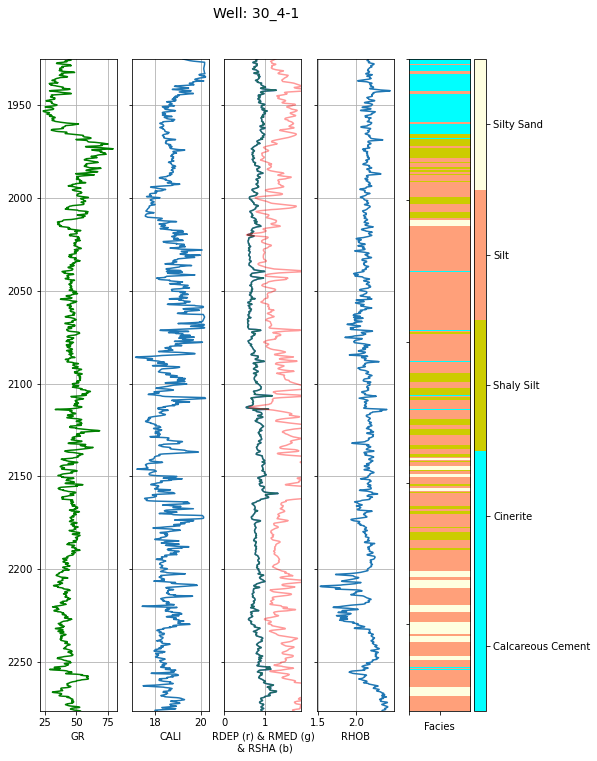

In [11]:
from deep_ml_curriculum.visualization.well_log import plot_facies, plot_well
well_name="30_4-1"
logs = df_all_clean[df_all_clean2.Well==well_name]
facies = logs['LITHOLOGY_GEOLINK'].astype('category').values
plot_well(well_name, 
          logs, 
          facies)

/home/wassname/anaconda/envs/deep_ml_curriculum/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


(<Figure size 576x864 with 6 Axes>,
 array([<AxesSubplot:xlabel='GR'>, <AxesSubplot:xlabel='CALI'>,
        <AxesSubplot:xlabel='RDEP (r) & RMED (g)\n & RSHA (b)'>,
        <AxesSubplot:xlabel='RHOB'>, <AxesSubplot:xlabel='Facies'>],
       dtype=object))

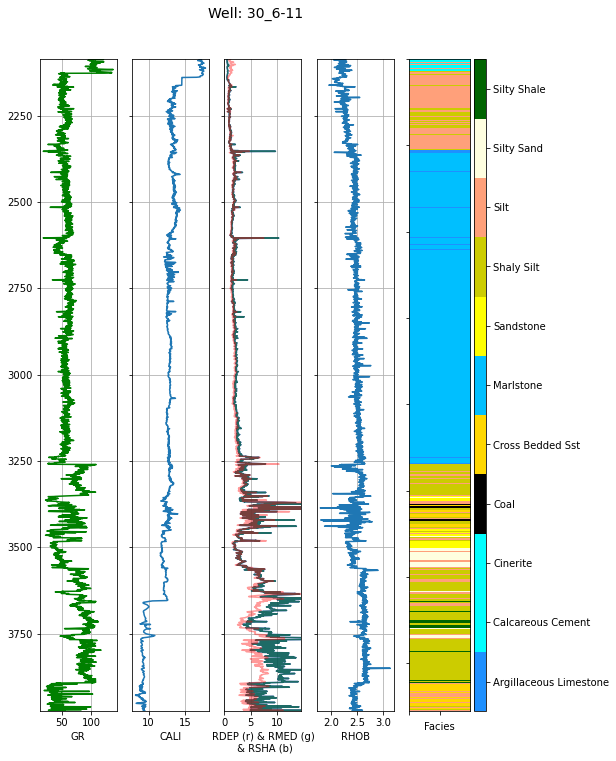

In [12]:
from deep_ml_curriculum.visualization.well_log import plot_facies, plot_well
well_name="30_6-11"
logs = df_all_clean[df_all_clean2.Well==well_name]
facies = logs['LITHOLOGY_GEOLINK'].astype('category').values
plot_well(well_name, 
          logs, 
          facies)

In [13]:
# Split by well name
# wells_val = [
#     "35_11-1",
#     "35_11-10",
#     "35_11-11",
#     "35_11-12",
#     "35_11-13",
#     "35_11-15 S",
#     "35_11-2",
#     "35_11-5",
#     "35_11-6",
#     "35_11-7",
#     "35_12-1",
# ]

wells_test = [
    "34_10-12",
    "34_10-16 R",
    "34_10-17",
    "34_10-19",
    "34_10-21",
    "34_10-23",
    "34_10-33",
    "34_10-35",
    "34_10-5",
    "34_10-7",
    "34_11-1",
    "34_11-2 S",
    "34_11-3 T2",
]

In [14]:
df_all_clean_test = df_all_clean[df_all_clean.Well.apply(lambda s: s in wells_test)]
df_all_clean_train = df_all_clean[
    df_all_clean.Well.apply(lambda s: (s not in wells_test))
]
# assert len(set(df_all_clean_val.Well).intersection(set(df_all_clean_train))) == 0
assert len(set(df_all_clean_test.Well).intersection(set(df_all_clean_train))) == 0
# assert len(set(df_all_clean_test.Well).intersection(set(df_all_clean_val))) == 0
len(df_all_clean_train), len(df_all_clean_test)

(700538, 44046)

In [15]:
df_all_clean_train.to_parquet(
    interim_locations / "geolink_norge_well_logs_train.parquet", compression="gzip"
)
df_all_clean_test.to_parquet(
    interim_locations / "geolink_norge_well_logs_test.parquet", compression="gzip"
)
# df_all_clean_val.to_parquet(
#     interim_locations / "geolink_norge_well_logs_val.parquet", compression="gzip"
# )

In [16]:
df_all_clean

,DEPT,LITHOLOGY_GEOLINK,CALI,DRHO,NPHI,RHOB,GR,DTC,RDEP,SP,RSHA,RMED,Well
11302,2215.917725,Shaly Silt,14.438001,0.010000,0.447725,2.363000,60.285748,134.253601,0.737006,50.570400,0.785088,0.785088,15_9-12
11303,2216.070068,Shaly Silt,14.633000,0.006000,0.432095,2.340000,63.250000,129.101868,0.741000,50.820000,0.840000,0.840000,15_9-12
11304,2216.222412,Shaly Silt,14.813001,0.006000,0.410166,2.314000,61.405998,122.476944,0.752000,50.820000,0.858000,0.858000,15_9-12
11305,2216.375000,Shaly Silt,14.383001,-0.001000,0.414143,2.293000,62.561596,116.908607,0.739962,51.070000,0.857046,0.857046,15_9-12
11306,2216.527344,Shaly Silt,14.202999,0.001000,0.439923,2.275000,61.691055,115.390953,0.715966,51.070602,0.886082,0.886082,15_9-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3134951,2723.585938,Anhydrite,9.157000,0.141856,0.000000,2.692753,15.846580,53.005497,1504.687866,59.057552,14.382000,1453.242920,7_3-1
3134952,2723.738525,Anhydrite,9.197000,0.148906,0.000000,2.695477,16.209375,53.386738,1514.930054,58.484932,14.387000,1471.283691,7_3-1
3134953,2723.890869,Anhydrite,9.236000,0.148817,0.000000,2.701625,16.638577,53.277893,1522.655029,58.483002,14.390000,1473.072998,7_3-1
3134954,2724.043213,Anhydrite,9.262000,0.150856,0.000000,2.702774,16.997316,52.928886,1530.355835,58.843422,14.390000,1473.072998,7_3-1


# Others

In [17]:
df_picks = pd.read_excel(
    data_locations / "../NPD stratigraphic picks north sea.xlsx", header=0
)
df_picks.to_parquet(
    interim_locations / "geolink_norge_picks.parquet", compression="gzip"
)

In [18]:
df_picks

,Unnamed: 0,Well identifier,Surface,X,Y,Z,MD,Geological age,TVT,TST,Interpreter,Observation number
0,21675,10/4-1,CROMER KNOLL GP. Top,628531.41,6394710.62,-1350.90,1382.0,4.21,NaN,NaN,NPD,1
1,21660,10/4-1,Roedby Fm. Top,628531.41,6394710.62,-1350.90,1382.0,98.90,NaN,NaN,NPD,1
2,21656,10/4-1,Sola Fm. Top,628531.47,6394710.62,-1381.90,1413.0,102.50,NaN,NaN,NPD,1
3,21664,10/4-1,Aasgard Fm. Top,628531.50,6394710.61,-1397.90,1429.0,117.00,NaN,NaN,NPD,1
4,21668,10/4-1,VESTLAND GP. Top,628531.27,6394713.59,-2242.88,2274.0,1.00,NaN,NaN,NPD,1
...,...,...,...,...,...,...,...,...,...,...,...,...
21671,18878,9/8-1,Vaale Fm. Top,580466.31,6356474.78,-1202.50,1233.0,0.00,NaN,NaN,NPD,1
21672,18877,9/8-1,NORDLAND GP. Top,580466.31,6356474.78,-67.50,98.0,0.00,NaN,NaN,NPD,1
21673,18876,9/8-1,BOKNFJORD GP. Top,580466.31,6356474.78,-1746.50,1777.0,1.00,NaN,NaN,NPD,1
21674,18868,9/8-1,Egersund Fm. Top,580466.31,6356474.78,-1794.50,1825.0,153.80,NaN,NaN,NPD,1


## Well heads part 2

In [19]:
# only wells we use
a = sorted(df_all.Well.unique())
df_well_tops = df_well_tops[
    df_well_tops["wlbWellboreName_geolink"].apply(lambda s: s in a)
]

In [20]:
df_well_tops.to_file(interim_locations / "norge_well_tops.gpkg", driver="GPKG")

# Example Load

<AxesSubplot:>

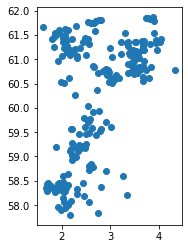

In [21]:
# Test load
df_all_clean2 = pd.read_parquet(
    interim_locations / "geolink_norge_well_logs_train.parquet"
)  # .set_index(['Well', 'DEPT'])

df_well_tops = gpd.read_file(interim_locations / "norge_well_tops.gpkg")
df_well_tops_minimal = df_well_tops[
    [
        "wlbWellboreName_geolink",
        "wlbCompletionYear",
        "wlbKellyBushElevation",
        "wlbCompletionDate",
        "wlbTotalDepth",
        "geometry",
    ]
]
df_well_tops.plot()

<AxesSubplot:>

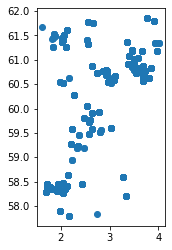

In [22]:
# Merge well tops and well logs, a selection
df_all_clean3 = pd.merge(
    left=df_all_clean2.sample(1000),
    right=df_well_tops_minimal,
    left_on="Well",
    right_on="wlbWellboreName_geolink",
    how="left",
).drop(columns="wlbWellboreName_geolink")
df_all_clean3 = df_all_clean3.set_index(['Well', 'DEPT'])
df_all_clean3 = gpd.GeoDataFrame(df_all_clean3, geometry=df_all_clean3['geometry'])
df_all_clean3.plot()
# df_all_clean3

In [23]:
df_picks = pd.read_parquet(interim_locations / "geolink_norge_picks.parquet")
df_picks

,Unnamed: 0,Well identifier,Surface,X,Y,Z,MD,Geological age,TVT,TST,Interpreter,Observation number
0,21675,10/4-1,CROMER KNOLL GP. Top,628531.41,6394710.62,-1350.90,1382.0,4.21,NaN,NaN,NPD,1
1,21660,10/4-1,Roedby Fm. Top,628531.41,6394710.62,-1350.90,1382.0,98.90,NaN,NaN,NPD,1
2,21656,10/4-1,Sola Fm. Top,628531.47,6394710.62,-1381.90,1413.0,102.50,NaN,NaN,NPD,1
3,21664,10/4-1,Aasgard Fm. Top,628531.50,6394710.61,-1397.90,1429.0,117.00,NaN,NaN,NPD,1
4,21668,10/4-1,VESTLAND GP. Top,628531.27,6394713.59,-2242.88,2274.0,1.00,NaN,NaN,NPD,1
...,...,...,...,...,...,...,...,...,...,...,...,...
21671,18878,9/8-1,Vaale Fm. Top,580466.31,6356474.78,-1202.50,1233.0,0.00,NaN,NaN,NPD,1
21672,18877,9/8-1,NORDLAND GP. Top,580466.31,6356474.78,-67.50,98.0,0.00,NaN,NaN,NPD,1
21673,18876,9/8-1,BOKNFJORD GP. Top,580466.31,6356474.78,-1746.50,1777.0,1.00,NaN,NaN,NPD,1
21674,18868,9/8-1,Egersund Fm. Top,580466.31,6356474.78,-1794.50,1825.0,153.80,NaN,NaN,NPD,1


In [24]:
df_all_clean = pd.read_parquet(
    interim_locations / "geolink_norge_well_logs_train.parquet"
).set_index(["Well", "DEPT"])
df_all_clean

LITHOLOGY_GEOLINK       CALI      DRHO      NPHI  \
Well    DEPT                                                           
15_9-12 2215.917725        Shaly Silt  14.438001  0.010000  0.447725   
        2216.070068        Shaly Silt  14.633000  0.006000  0.432095   
        2216.222412        Shaly Silt  14.813001  0.006000  0.410166   
        2216.375000        Shaly Silt  14.383001 -0.001000  0.414143   
        2216.527344        Shaly Silt  14.202999  0.001000  0.439923   
...                               ...        ...       ...       ...   
7_3-1   2723.585938         Anhydrite   9.157000  0.141856  0.000000   
        2723.738525         Anhydrite   9.197000  0.148906  0.000000   
        2723.890869         Anhydrite   9.236000  0.148817  0.000000   
        2724.043213         Anhydrite   9.262000  0.150856  0.000000   
        2724.195557         Anhydrite   9.268000  0.145638  0.000000   

                         RHOB         GR         DTC         RDEP         SP  \
Well    DEPT                                                                   
15_9-12 2215.917725  2.363000  60.285748  134.253601     0.737006  50.570400   
        2216.070068  2.340000  63.250000  129.101868     0.741000  50.820000   
        2216.222412  2.314000  61.405998  122.476944     0.752000  50.820000   
        2216.375000  2.293000  62.561596  116.908607     0.739962  51.070000   
        2216.527344  2.275000  61.691055  115.390953     0.715966  51.070602   
...                       ...        ...         ...          ...        ...   
7_3-1   2723.585938  2.692753  15.846580   53.005497  1504.687866  59.057552   
        2723.738525  2.695477  16.209375   53.386738  1514.930054  58.484932   
        2723.890869  2.701625  16.638577   53.277893  1522.655029  58.483002   
        2724.043213  2.702774  16.997316   52.928886  1530.355835  58.843422   
        2724.195557  2.690725  17.194046   52.892044  1538.068726  59.203846   

                          RSHA         RMED  
Well    DEPT                                 
15_9-12 2215.917725   0.785088     0.785088  
        2216.070068   0.840000     0.840000  
        2216.222412   0.858000     0.858000  
        2216.375000   0.857046     0.857046  
        2216.527344   0.886082     0.886082  
...                        ...          ...  
7_3-1   2723.585938  14.382000  1453.242920  
        2723.738525  14.387000  1471.283691  
        2723.890869  14.390000  1473.072998  
        2724.043213  14.390000  1473.072998  
        2724.195557  14.389000  1473.072998  

[700538 rows x 11 columns]

# Example plot

In [25]:
df_all_clean = pd.read_parquet(
    interim_locations / "geolink_norge_well_logs_train.parquet"
).set_index(["Well", "DEPT"])
df_all_clean['DEPT'] = df_all_clean.index.get_level_values(1)
df_all_clean

LITHOLOGY_GEOLINK       CALI      DRHO      NPHI  \
Well    DEPT                                                           
15_9-12 2215.917725        Shaly Silt  14.438001  0.010000  0.447725   
        2216.070068        Shaly Silt  14.633000  0.006000  0.432095   
        2216.222412        Shaly Silt  14.813001  0.006000  0.410166   
        2216.375000        Shaly Silt  14.383001 -0.001000  0.414143   
        2216.527344        Shaly Silt  14.202999  0.001000  0.439923   
...                               ...        ...       ...       ...   
7_3-1   2723.585938         Anhydrite   9.157000  0.141856  0.000000   
        2723.738525         Anhydrite   9.197000  0.148906  0.000000   
        2723.890869         Anhydrite   9.236000  0.148817  0.000000   
        2724.043213         Anhydrite   9.262000  0.150856  0.000000   
        2724.195557         Anhydrite   9.268000  0.145638  0.000000   

                         RHOB         GR         DTC         RDEP         SP  \
Well    DEPT                                                                   
15_9-12 2215.917725  2.363000  60.285748  134.253601     0.737006  50.570400   
        2216.070068  2.340000  63.250000  129.101868     0.741000  50.820000   
        2216.222412  2.314000  61.405998  122.476944     0.752000  50.820000   
        2216.375000  2.293000  62.561596  116.908607     0.739962  51.070000   
        2216.527344  2.275000  61.691055  115.390953     0.715966  51.070602   
...                       ...        ...         ...          ...        ...   
7_3-1   2723.585938  2.692753  15.846580   53.005497  1504.687866  59.057552   
        2723.738525  2.695477  16.209375   53.386738  1514.930054  58.484932   
        2723.890869  2.701625  16.638577   53.277893  1522.655029  58.483002   
        2724.043213  2.702774  16.997316   52.928886  1530.355835  58.843422   
        2724.195557  2.690725  17.194046   52.892044  1538.068726  59.203846   

                          RSHA         RMED         DEPT  
Well    DEPT                                              
15_9-12 2215.917725   0.785088     0.785088  2215.917725  
        2216.070068   0.840000     0.840000  2216.070068  
        2216.222412   0.858000     0.858000  2216.222412  
        2216.375000   0.857046     0.857046  2216.375000  
        2216.527344   0.886082     0.886082  2216.527344  
...                        ...          ...          ...  
7_3-1   2723.585938  14.382000  1453.242920  2723.585938  
        2723.738525  14.387000  1471.283691  2723.738525  
        2723.890869  14.390000  1473.072998  2723.890869  
        2724.043213  14.390000  1473.072998  2724.043213  
        2724.195557  14.389000  1473.072998  2724.195557  

[700538 rows x 12 columns]

(<Figure size 576x864 with 6 Axes>,
 array([<AxesSubplot:xlabel='GR'>, <AxesSubplot:xlabel='CALI'>,
        <AxesSubplot:xlabel='RDEP (r) & RMED (g)\n & RSHA (b)'>,
        <AxesSubplot:xlabel='RHOB'>, <AxesSubplot:xlabel='Facies'>],
       dtype=object))

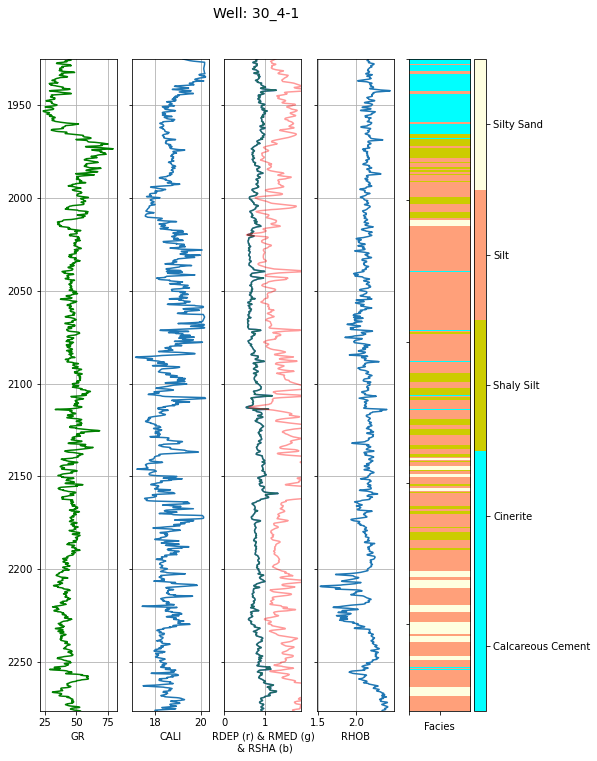

In [26]:
from deep_ml_curriculum.visualization.well_log import plot_facies, plot_well
well_name="30_4-1"
logs = df_all_clean.xs(well_name)
facies = logs['LITHOLOGY_GEOLINK'].astype('category').values
plot_well(well_name, 
          logs, 
          facies)

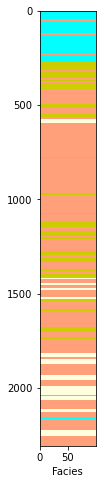

In [27]:
plt.figure(figsize=(1,8))
plot_facies(facies, plt.gca(), colorbar=False)

# reindex depth and to Xarray

This lets us includes location easily without using much more space

In [45]:
# Load some
df_all_clean1 = pd.read_parquet(
    interim_locations / "geolink_norge_well_logs_test.parquet"
).set_index(['Well', 'DEPT'])
df_all_clean1['Depth'] = df_all_clean1.index.get_level_values(1)
df_all_clean1['split'] = 'test'

# Load some
df_all_clean2 = pd.read_parquet(
    interim_locations / "geolink_norge_well_logs_train.parquet"
).set_index(['Well', 'DEPT'])
df_all_clean2['Depth'] = df_all_clean2.index.get_level_values(1)
df_all_clean2['split'] = 'train'

# # Load some
# df_all_clean3 = pd.read_parquet(
#     interim_locations / "geolink_norge_well_logs_val.parquet"
# ).set_index(['Well', 'DEPT'])
# df_all_clean3['Depth'] = df_all_clean3.index.get_level_values(1)
# df_all_clean3['split'] = 'val'

df_all = pd.concat([df_all_clean1, df_all_clean2])
df_all

LITHOLOGY_GEOLINK    CALI      DRHO     NPHI      RHOB  \
Well     DEPT                                                                 
34_10-12 1930.174316         Marlstone  12.977 -0.012000  0.48633  2.168000   
         1930.326660         Marlstone  13.273 -0.019000  0.44824  2.150000   
         1930.479126         Marlstone  13.570 -0.028000  0.40479  2.137000   
         1930.631470         Marlstone  14.016 -0.026000  0.39746  2.139000   
         1930.783813         Marlstone  13.883 -0.017000  0.40332  2.143000   
...                                ...     ...       ...      ...       ...   
7_3-1    2723.585938         Anhydrite   9.157  0.141856  0.00000  2.692753   
         2723.738525         Anhydrite   9.197  0.148906  0.00000  2.695477   
         2723.890869         Anhydrite   9.236  0.148817  0.00000  2.701625   
         2724.043213         Anhydrite   9.262  0.150856  0.00000  2.702774   
         2724.195557         Anhydrite   9.268  0.145638  0.00000  2.690725   

                             GR         DTC         RDEP         SP  \
Well     DEPT                                                         
34_10-12 1930.174316  39.741283  131.493591     0.900000  65.886795   
         1930.326660  37.034103  129.506012     0.894000  65.514198   
         1930.479126  38.006210  131.366592     0.894000  65.889206   
         1930.631470  39.944405  128.745590     0.896000  66.264603   
         1930.783813  41.935070  127.375900     0.900000  66.763603   
...                         ...         ...          ...        ...   
7_3-1    2723.585938  15.846580   53.005497  1504.687866  59.057552   
         2723.738525  16.209375   53.386738  1514.930054  58.484932   
         2723.890869  16.638577   53.277893  1522.655029  58.483002   
         2724.043213  16.997316   52.928886  1530.355835  58.843422   
         2724.195557  17.194046   52.892044  1538.068726  59.203846   

                           RSHA         RMED        Depth  split  
Well     DEPT                                                     
34_10-12 1930.174316   0.893119     0.893119  1930.174316   test  
         1930.326660   0.930102     0.930102  1930.326660   test  
         1930.479126   0.962067     0.962067  1930.479126   test  
         1930.631470   0.983128     0.983128  1930.631470   test  
         1930.783813   1.022998     1.022998  1930.783813   test  
...                         ...          ...          ...    ...  
7_3-1    2723.585938  14.382000  1453.242920  2723.585938  train  
         2723.738525  14.387000  1471.283691  2723.738525  train  
         2723.890869  14.390000  1473.072998  2723.890869  train  
         2724.043213  14.390000  1473.072998  2724.043213  train  
         2724.195557  14.389000  1473.072998  2724.195557  train  

[744584 rows x 13 columns]

In [29]:
df_well_tops = gpd.read_file(interim_locations / "norge_well_tops.gpkg")
df_well_tops_minimal = df_well_tops[
    [
        "wlbWellboreName_geolink",
        "wlbCompletionYear",
        "wlbKellyBushElevation",
        "wlbCompletionDate",
        "wlbTotalDepth",
        "geometry",
    ]
].copy()
df_well_tops_minimal['xc'] = df_well_tops_minimal.geometry.x
df_well_tops_minimal['yc'] = df_well_tops_minimal.geometry.y
df_well_tops_minimal

,wlbWellboreName_geolink,wlbCompletionYear,wlbKellyBushElevation,wlbCompletionDate,wlbTotalDepth,geometry,xc,yc
0,6_3-1,1985,23.0,1985-01-02T00:00:00,3560.0,POINT (1.92511 57.96950),1.925106,57.969500
1,6_3-2,1986,22.0,1986-10-03T00:00:00,4091.0,POINT (1.98727 57.90722),1.987275,57.907219
2,7_1-1,1971,34.0,1971-05-08T00:00:00,2808.0,POINT (2.16556 57.79778),2.165556,57.797778
3,7_1-2 S,2008,44.0,2008-08-05T00:00:00,3175.0,POINT (2.06967 57.93252),2.069672,57.932525
4,7_3-1,1969,31.0,1969-10-06T00:00:00,4700.0,POINT (2.74878 57.84313),2.748781,57.843125
...,...,...,...,...,...,...,...,...
216,35_11-15 S,2007,26.0,2007-06-28T00:00:00,3250.0,POINT (3.52221 61.11397),3.522206,61.113967
217,35_12-1,1992,26.0,1992-04-24T00:00:00,3020.0,POINT (3.96261 61.18446),3.962614,61.184461
218,35_12-4 S,2011,29.0,2011-06-26T00:00:00,3585.0,POINT (3.69150 61.18521),3.691500,61.185211
219,36_7-1,1996,22.0,1996-07-05T00:00:00,2841.0,POINT (4.01589 61.35375),4.015894,61.353747


In [40]:
nidx = np.arange(400, 5500, 0.15)

In [48]:
def reindex(x):
    """Reindex each well to 15cm"""
    if len(x)==0: return None
    x = x.reset_index().set_index('DEPT')
    x = x.reindex(nidx, method='nearest', limit=1).drop(columns=['Well']).sort_index()
    return x
#     return x.reset_index().set_index(['Well', 'DEPT'])

df_all3 = df_all.groupby(level=0).apply(reindex).dropna()
df_all3

LITHOLOGY_GEOLINK       CALI      DRHO      NPHI      RHOB  \
Well    DEPT                                                                 
15_9-12 2215.90        Shaly Silt  14.438001  0.010000  0.447725  2.363000   
        2216.05        Shaly Silt  14.633000  0.006000  0.432095  2.340000   
        2216.20        Shaly Silt  14.813001  0.006000  0.410166  2.314000   
        2216.35        Shaly Silt  14.383001 -0.001000  0.414143  2.293000   
        2216.50        Shaly Silt  14.202999  0.001000  0.439923  2.275000   
...                           ...        ...       ...       ...       ...   
7_3-1   2723.65         Anhydrite   9.157000  0.141856  0.000000  2.692753   
        2723.80         Anhydrite   9.197000  0.148906  0.000000  2.695477   
        2723.95         Anhydrite   9.236000  0.148817  0.000000  2.701625   
        2724.10         Anhydrite   9.262000  0.150856  0.000000  2.702774   
        2724.25         Anhydrite   9.268000  0.145638  0.000000  2.690725   

                        GR         DTC         RDEP         SP       RSHA  \
Well    DEPT                                                                
15_9-12 2215.90  60.285748  134.253601     0.737006  50.570400   0.785088   
        2216.05  63.250000  129.101868     0.741000  50.820000   0.840000   
        2216.20  61.405998  122.476944     0.752000  50.820000   0.858000   
        2216.35  62.561596  116.908607     0.739962  51.070000   0.857046   
        2216.50  61.691055  115.390953     0.715966  51.070602   0.886082   
...                    ...         ...          ...        ...        ...   
7_3-1   2723.65  15.846580   53.005497  1504.687866  59.057552  14.382000   
        2723.80  16.209375   53.386738  1514.930054  58.484932  14.387000   
        2723.95  16.638577   53.277893  1522.655029  58.483002  14.390000   
        2724.10  16.997316   52.928886  1530.355835  58.843422  14.390000   
        2724.25  17.194046   52.892044  1538.068726  59.203846  14.389000   

                        RMED        Depth  split  
Well    DEPT                                      
15_9-12 2215.90     0.785088  2215.917725  train  
        2216.05     0.840000  2216.070068  train  
        2216.20     0.858000  2216.222412  train  
        2216.35     0.857046  2216.375000  train  
        2216.50     0.886082  2216.527344  train  
...                      ...          ...    ...  
7_3-1   2723.65  1453.242920  2723.585938  train  
        2723.80  1471.283691  2723.738525  train  
        2723.95  1473.072998  2723.890869  train  
        2724.10  1473.072998  2724.043213  train  
        2724.25  1473.072998  2724.195557  train  

[725981 rows x 13 columns]

In [49]:
import xarray as xr
xr_all_clean2 = df_all3.to_xarray()
xr_all_clean2

<xarray.Dataset>
Dimensions:            (DEPT: 33472, Well: 118)
Coordinates:
  * Well               (Well) object '15_9-12' '15_9-13' ... '7_1-1' '7_3-1'
  * DEPT               (DEPT) float64 414.7 414.8 415.0 ... 5.435e+03 5.435e+03
Data variables:
    LITHOLOGY_GEOLINK  (Well, DEPT) object nan nan nan nan ... nan nan nan nan
    CALI               (Well, DEPT) float64 nan nan nan nan ... nan nan nan nan
    DRHO               (Well, DEPT) float64 nan nan nan nan ... nan nan nan nan
    NPHI               (Well, DEPT) float64 nan nan nan nan ... nan nan nan nan
    RHOB               (Well, DEPT) float64 nan nan nan nan ... nan nan nan nan
    GR                 (Well, DEPT) float64 nan nan nan nan ... nan nan nan nan
    DTC                (Well, DEPT) float64 nan nan nan nan ... nan nan nan nan
    RDEP               (Well, DEPT) float64 nan nan nan nan ... nan nan nan nan
    SP                 (Well, DEPT) float64 nan nan nan nan ... nan nan nan nan
    RSHA               (Well, DEPT) float64 nan nan nan nan ... nan nan nan nan
    RMED               (Well, DEPT) float64 nan nan nan nan ... nan nan nan nan
    Depth              (Well, DEPT) float64 nan nan nan nan ... nan nan nan nan
    split              (Well, DEPT) object nan nan nan nan ... nan nan nan nan

In [50]:
xr_wells = df_well_tops_minimal.rename(columns={'wlbWellboreName_geolink':'Well'}).set_index('Well').to_xarray()
xr_wells

<xarray.Dataset>
Dimensions:                (Well: 221)
Coordinates:
  * Well                   (Well) object '6_3-1' '6_3-2' ... '36_7-1' '36_7-3'
Data variables:
    wlbCompletionYear      (Well) int64 1985 1986 1971 2008 ... 2011 1996 2002
    wlbKellyBushElevation  (Well) float64 23.0 22.0 34.0 44.0 ... 29.0 22.0 24.0
    wlbCompletionDate      (Well) object '1985-01-02T00:00:00' ... '2002-06-0...
    wlbTotalDepth          (Well) float64 3.56e+03 4.091e+03 ... 2.948e+03
    geometry               (Well) object POINT (1.925106 57.9695) ... POINT (...
    xc                     (Well) float64 1.925 1.987 2.166 ... 3.692 4.016 4.05
    yc                     (Well) float64 57.97 57.91 57.8 ... 61.19 61.35 61.43

In [51]:
xr_all = xr.merge(
    [xr_all_clean2, xr_wells],
    join='left')

In [52]:
xr_all2 = xr_all.sortby(['Well', 'DEPT'])
xr_all2

<xarray.Dataset>
Dimensions:                (DEPT: 33472, Well: 118)
Coordinates:
  * Well                   (Well) object '15_9-12' '15_9-13' ... '7_1-1' '7_3-1'
  * DEPT                   (DEPT) float64 414.7 414.8 ... 5.435e+03 5.435e+03
Data variables:
    LITHOLOGY_GEOLINK      (Well, DEPT) object nan nan nan nan ... nan nan nan
    CALI                   (Well, DEPT) float64 nan nan nan nan ... nan nan nan
    DRHO                   (Well, DEPT) float64 nan nan nan nan ... nan nan nan
    NPHI                   (Well, DEPT) float64 nan nan nan nan ... nan nan nan
    RHOB                   (Well, DEPT) float64 nan nan nan nan ... nan nan nan
    GR                     (Well, DEPT) float64 nan nan nan nan ... nan nan nan
    DTC                    (Well, DEPT) float64 nan nan nan nan ... nan nan nan
    RDEP                   (Well, DEPT) float64 nan nan nan nan ... nan nan nan
    SP                     (Well, DEPT) float64 nan nan nan nan ... nan nan nan
    RSHA                   (Well, DEPT) float64 nan nan nan nan ... nan nan nan
    RMED                   (Well, DEPT) float64 nan nan nan nan ... nan nan nan
    Depth                  (Well, DEPT) float64 nan nan nan nan ... nan nan nan
    split                  (Well, DEPT) object nan nan nan nan ... nan nan nan
    wlbCompletionYear      (Well) int64 1982 1982 1982 1982 ... 1986 1971 1969
    wlbKellyBushElevation  (Well) float64 25.0 25.0 25.0 25.0 ... 22.0 34.0 31.0
    wlbCompletionDate      (Well) object '1982-02-27T00:00:00' ... '1969-10-0...
    wlbTotalDepth          (Well) float64 3.74e+03 3.28e+03 ... 4.7e+03
    geometry               (Well) object POINT (1.717781 58.456436) ... POINT...
    xc                     (Well) float64 1.718 1.934 1.691 ... 2.166 2.749
    yc                     (Well) float64 58.46 58.37 58.29 ... 57.91 57.8 57.84

,Well,LITHOLOGY_GEOLINK,CALI,DRHO,NPHI,RHOB,GR,DTC,RDEP,SP,...,Depth,split,wlbCompletionYear,wlbKellyBushElevation,wlbCompletionDate,wlbTotalDepth,geometry,xc,yc,DEPT
DEPT,,,,,,,,,,,,,,,,,,,,,
1924.90,30_4-1,Silt,19.229000,-0.004000,0.407435,2.160033,43.573063,125.354637,1.271021,51.008926,...,1925.031860,train,1979,24.3,1979-05-14T00:00:00,5454.0,POINT (2.159614 60.622464),2.159614,60.622464,1925.031860
1925.05,30_4-1,Silt,19.229000,-0.004000,0.407435,2.160033,43.573063,125.354637,1.271021,51.008926,...,1925.031860,train,1979,24.3,1979-05-14T00:00:00,5454.0,POINT (2.159614 60.622464),2.159614,60.622464,1925.031860
1925.20,30_4-1,Cinerite,19.264000,0.001000,0.399621,2.157022,44.785027,123.796204,1.257022,52.834549,...,1925.184204,train,1979,24.3,1979-05-14T00:00:00,5454.0,POINT (2.159614 60.622464),2.159614,60.622464,1925.184204
1925.35,30_4-1,Cinerite,19.312000,0.003000,0.392289,2.160177,45.022621,122.600998,1.239043,53.518486,...,1925.336548,train,1979,24.3,1979-05-14T00:00:00,5454.0,POINT (2.159614 60.622464),2.159614,60.622464,1925.336548
1925.50,30_4-1,Cinerite,19.360001,0.004000,0.398116,2.163876,45.389706,122.731598,1.225022,54.125484,...,1925.489014,train,1979,24.3,1979-05-14T00:00:00,5454.0,POINT (2.159614 60.622464),2.159614,60.622464,1925.489014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2276.05,30_4-1,Silt,18.073999,0.047958,-0.055140,2.364307,48.278000,101.582390,1.683030,71.094002,...,2276.009033,train,1979,24.3,1979-05-14T00:00:00,5454.0,POINT (2.159614 60.622464),2.159614,60.622464,2276.009033
2276.20,30_4-1,Silt,18.000999,0.045010,-0.056777,2.347309,50.699120,103.808281,1.692984,72.750999,...,2276.161377,train,1979,24.3,1979-05-14T00:00:00,5454.0,POINT (2.159614 60.622464),2.159614,60.622464,2276.161377
2276.35,30_4-1,Silt,18.020000,0.025096,-0.058328,2.346604,51.971962,103.750862,1.701986,74.087997,...,2276.313721,train,1979,24.3,1979-05-14T00:00:00,5454.0,POINT (2.159614 60.622464),2.159614,60.622464,2276.313721


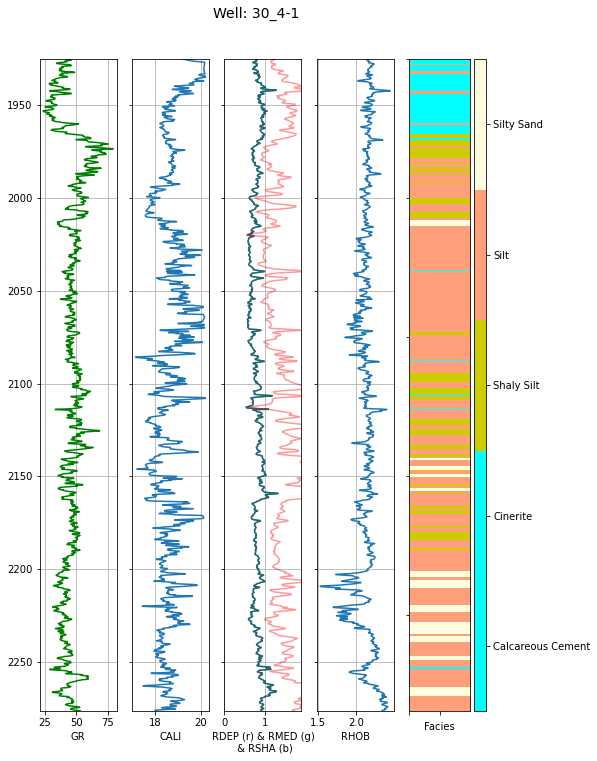

In [53]:
well_name="30_4-1"
logs = xr_all2.sel(Well=well_name).to_dataframe().dropna()
logs['DEPT'] = logs['Depth']
facies = logs['LITHOLOGY_GEOLINK'].astype('category').values
plot_well(well_name, logs, facies)
logs

,LITHOLOGY_GEOLINK,CALI,DRHO,NPHI,RHOB,GR,DTC,RDEP,SP,RSHA,RMED,DEPT
DEPT,,,,,,,,,,,,
1925.031860,Silt,19.229000,-0.004000,0.407435,2.160033,43.573063,125.354637,1.271021,51.008926,0.817970,0.817970,1925.031860
1925.184204,Cinerite,19.264000,0.001000,0.399621,2.157022,44.785027,123.796204,1.257022,52.834549,0.798987,0.798987,1925.184204
1925.336548,Cinerite,19.312000,0.003000,0.392289,2.160177,45.022621,122.600998,1.239043,53.518486,0.783000,0.783000,1925.336548
1925.489014,Cinerite,19.360001,0.004000,0.398116,2.163876,45.389706,122.731598,1.225022,54.125484,0.783000,0.783000,1925.489014
1925.641357,Cinerite,19.408001,0.004000,0.414166,2.159730,45.909168,123.638924,1.211034,54.728302,0.783002,0.783002,1925.641357
...,...,...,...,...,...,...,...,...,...,...,...,...
2276.009033,Silt,18.073999,0.047958,-0.055140,2.364307,48.278000,101.582390,1.683030,71.094002,0.903010,0.903010,2276.009033
2276.161377,Silt,18.000999,0.045010,-0.056777,2.347309,50.699120,103.808281,1.692984,72.750999,0.909014,0.909014,2276.161377
2276.313721,Silt,18.020000,0.025096,-0.058328,2.346604,51.971962,103.750862,1.701986,74.087997,0.918000,0.918000,2276.313721


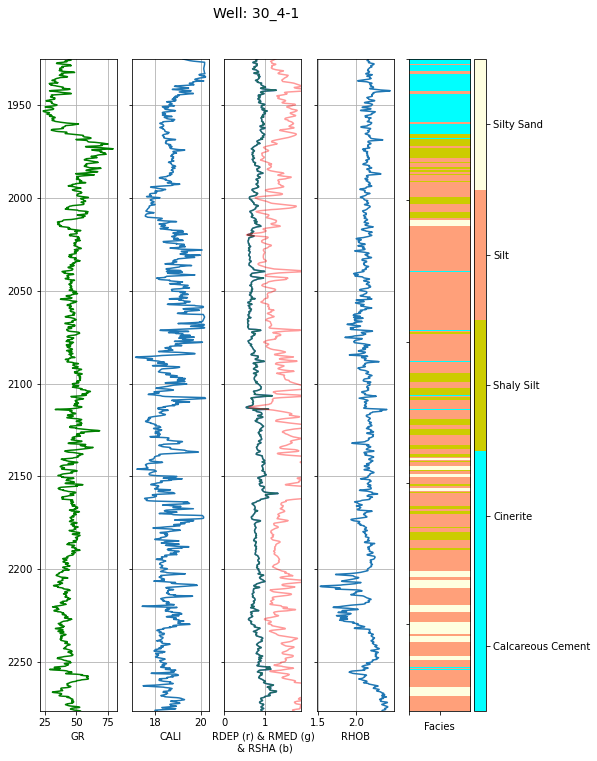

In [54]:
from deep_ml_curriculum.visualization.well_log import plot_facies, plot_well
well_name="30_4-1"
logs = df_all_clean.xs(well_name)
facies = logs['LITHOLOGY_GEOLINK'].astype('category').values
plot_well(well_name, 
          logs, 
          facies)
logs

In [56]:
# def dset_to_nc(dset, f, engine="netcdf4", compression={"zlib": True}):
#     if isinstance(dset, xr.DataArray):
#         dset = dset.to_dataset(name="data")
#     encoding = {k: {"zlib": True} for k in dset.data_vars}
#     print('saving to {}'.format(f))
#     dset.to_netcdf(f, engine=engine, encoding=encoding)
#     print('Wrote {}.nc size={} M'.format(f.stem, f.stat().st_size / 1000000.0))

In [57]:
# dset_to_nc(dset=xr_all.drop(['geometry']),
#           f=interim_locations/'geolink_norge_well_logs.h5')

saving to ../../data/processed/geolink_norge_dataset/geolink_norge_well_logs.h5


KeyboardInterrupt: 

In [58]:
import os, shutil

def get_dir_size(start_path="."):
    total_size = 0
    for dirpath, dirnames, filenames in os.walk(start_path):
        for f in filenames:
            fp = os.path.join(dirpath, f)
            total_size += os.path.getsize(fp)
    return total_size

def dset_to_zarr(dset, f):
    if isinstance(dset, xr.DataArray):
        dset = dset.to_dataset(name="data")
    encoding = {k: {"zlib": True} for k in dset.data_vars}
    print('saving to {}'.format(f))
    if f.exists():
        try:
            return xr.open_zarr(f)
        except:
            shutil.rmtree(f)
    dset.to_zarr(str(f))
    print('{}.zarr size={} M'.format(f.stem, get_dir_size(str(f)) / 1000000.0))
    
dset_to_zarr(dset=xr_all.drop(['geometry']),
          f=interim_locations/'geolink_norge_well_logs.zarr')

saving to ../../data/processed/geolink_norge_dataset/geolink_norge_well_logs.zarr
geolink_norge_well_logs.zarr size=49.057065 M


# Plot map

In [59]:
import matplotlib.pyplot as plt
%matplotlib inline
import os
from tqdm.auto import tqdm
import pandas as pd
import geopandas as gpd
import numpy as np

In [60]:
# import pandas as pd
# import xarray as xr
# xf = xr.open_zarr("../../data/processed/geolink_norge_dataset/geolink_norge_well_logs.zarr")
# df = xf.to_dataframe().swaplevel().sample(1000)
# df['LITHOLOGY_GEOLINK'] = df['LITHOLOGY_GEOLINK'].astype('category')
# df['Well'] = df.index.get_level_values(0).astype('category')
# df['DEPT'] = df.index.get_level_values(1)
# feature_cols = ['CALI', 'DTC', 'GR', 'RDEP', 'RHOB',
#        'RMED', 'xc', 'yc', 'DEPT']
# df = df.dropna(how='any', subset=feature_cols+['LITHOLOGY_GEOLINK'])
# df = df.sort_index()

# import geopandas as gpd
# gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.xc, df.yc))
# gdf = gdf.set_crs(epsg=4326).to_crs(epsg=3857)
# gdf.plot()

# Plot contextily

In [61]:
from pathlib import Path
interim_locations = Path("../../data/processed/geolink_norge_dataset/")
df_well_tops = gpd.read_file(interim_locations / "norge_well_tops.gpkg").set_crs(epsg=4326).to_crs(epsg=3857)#.head(40)
# df_well_tops.plot()

/home/wassname/anaconda/envs/deep_ml_curriculum/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: The "url" option is deprecated. Please use the "source" argument instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/wassname/anaconda/envs/deep_ml_curriculum/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  # This is added back by InteractiveShellApp.init_path()


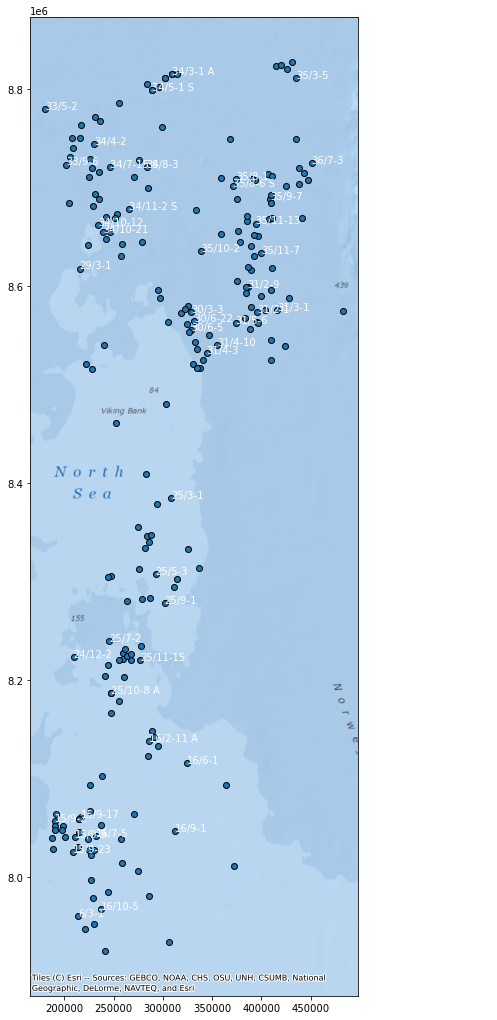

In [62]:


import contextily as ctx
ax = df_well_tops.plot(figsize=(18, 18), edgecolor='k')
ctx.add_basemap(ax, url=ctx.providers.Esri.OceanBasemap, zoom=8)

# Plot every 5th
df_well_tops[::5].apply(lambda x: 
                   ax.annotate(
                       s=x.wlbWellboreName, 
                       xy=x.geometry.centroid.coords[0], 
                       ha='left',
                       c='white',
                       
                   ), axis=1);

/home/wassname/anaconda/envs/deep_ml_curriculum/lib/python3.7/site-packages/contextily/tile.py:353: RasterioDeprecationWarning: Source dataset should be opened in read-only mode. Use of datasets opened in modes other than 'r' will be disallowed in a future version.
  img.transpose(2, 0, 1), transform, "EPSG:3857", t_crs, resampling
/home/wassname/anaconda/envs/deep_ml_curriculum/lib/python3.7/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  


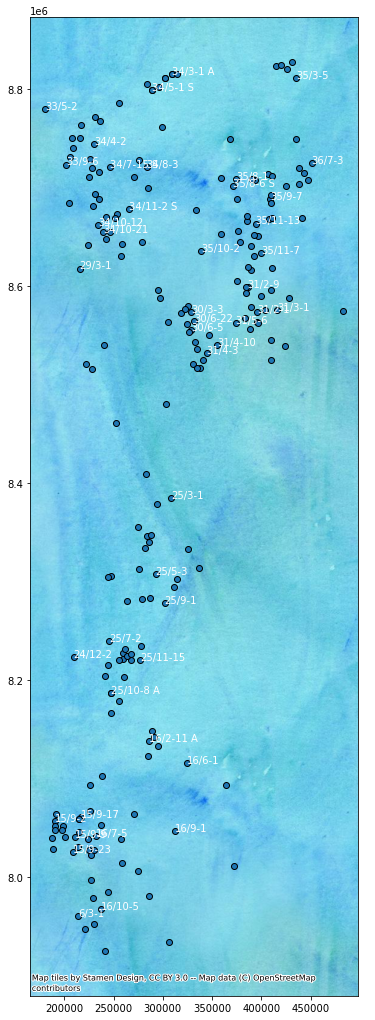

In [63]:
ax = df_well_tops.plot(figsize=(18, 18), edgecolor='k')
# ctx.add_basemap(ax, url=ctx.providers.Esri.OceanBasemap)
ctx.add_basemap(ax,
                crs=df_well_tops.crs.to_string(),
                source=ctx.providers.Stamen.Watercolor
               )

# Plot every 5th
df_well_tops[::5].apply(lambda x: 
                   ax.annotate(
                       s=x.wlbWellboreName, 
                       xy=x.geometry.centroid.coords[0], 
                       ha='left',
                       c='white'
                   ), axis=1);


In [64]:
west, south, east, north = bbox = df_well_tops.total_bounds
img, ext = ctx.bounds2raster(west,
                             south,
                             east,
                             north,
                             "world_watercolor.tif",
                             source=ctx.providers.Stamen.Watercolor,
                             ll=True,
                             zoom=8
                            )


KeyboardInterrupt: 

In [ ]:
west, south, east, north = bbox = df_well_tops.total_bounds
img, ext = ctx.bounds2raster(west,
                             south,
                             east,
                             north,
                             "oceanesri.tif",
                             source=ctx.providers.Esri.OceanBasemap,
                             ll=True,
                             zoom=8
                            )


In [ ]:
ctx.bounds2raster?